In [29]:
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, BayesianRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")


num_assets = 98
initial_weights = np.ones(num_assets) / num_assets
w_ew = initial_weights

def portfolio_variance(weights, cov_matrix):
    '''
    Function to calculate portfolio variance
    '''
    return weights.T @ cov_matrix @ weights


def calculate_minvar_portfolio(cov_matrix):
    '''
    Function to calculate MinVar portfolio weights
    '''
    num_assets = cov_matrix.shape[0]
    initial_guess = np.repeat(1 / num_assets, num_assets) # Equally weighted
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Constraint: Sum of weights is 1
    bounds = [(-1, 1) for _ in range(num_assets)]  # Allow for negative weights too
    result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,), bounds=bounds, constraints=constraints)
    return result.x


def sharpe_ratio(returns, risk_free_rate=0):
    '''
    Sharpe Ratio calculation
    '''
    return (np.mean(returns) - risk_free_rate) / np.std(returns)

def get_min_var_weights(training_data):
    '''
    Function to compute the minVar portfolio weights using the past 252 days of data
    '''
    cov_matrix = training_data.cov()

    # Get MinVar portfolio weights using the training data covariance matrix
    minvar_weights = calculate_minvar_portfolio(cov_matrix)

    return minvar_weights

def window_252(data, df_current_year, weights_func):
    '''
    sliding window with window size 252
    '''
    window_size = 252

    # prepare empty dataframe
    df_weights = pd.DataFrame(index=df_current_year.index, columns=data.columns)

    # obtain weights using get_min_var_weights
    for date in tqdm.tqdm(df_current_year.index): # (2024-01-02 ~ 2024-08-30)
        # Get the past 252 days of returns (not including target date)
        training_data = data.loc[:date].tail(window_size+1).head(window_size)

        # Check if we have enough data (i.e., exactly 252 days of historical data)
        if len(training_data) == window_size:
            # Get the minVar portfolio weights for this window
            weights = weights_func(training_data)
            
            # Store the weights in the result DataFrame
            df_weights.loc[date] = weights
    return df_weights

def create_N_matrix(n_assets):
    '''
    Linear Regression Setup  
    '''
    minus_1_T = -np.ones((1, n_assets-1))
    I_p_minus_1 = np.eye(n_assets-1)
    N = np.vstack([block_diag(I_p_minus_1), minus_1_T])
    return N


def prepare_regression_data(training_data, w_ew=initial_weights):
    """
    Function to create X (independent variable) and y (dependent variable) for regression
    w_ew: equally weighted portfolio
    """
    n_assets = training_data.shape[1]
    
    # Demean the training data (X)
    X = training_data - training_data.mean()  # Demeaned data
    
    # Create N matrix (for regression transformation)
    N = create_N_matrix(n_assets)
    
    # Create y (dependent variable) which is the difference between w_ew and actual weights
    y = X @ w_ew
    
    # Transform X using N matrix
    X_transformed = X @ N
    
    return X_transformed, y


def lasso_regression(X, y):
    '''
    LASSO with cross-validation
    '''
    lasso = LassoCV(cv=5, alphas=np.logspace(-8, 8, 100), fit_intercept=False)
    lasso.fit(X, y)
    return lasso.coef_

def ridge_regression(X, y):
    '''
    Ridge with cross-validation
    '''
    ridge = RidgeCV(alphas=np.logspace(-8, 8, 100), fit_intercept=False)
    ridge.fit(X, y)
    return ridge.coef_

def calculate_portfolio_weights(w_ew, beta, N):
    """
    Calculate portfolio weights using the regression coefficients.
    w_ew: Equally weighted portfolio
    beta: Regression coefficients (LASSO or Ridge)
    N: Transformation matrix
    """
    return w_ew - N @ beta

def get_lasso_weight(training_data, w_ew=initial_weights):

    X_train, y_train = prepare_regression_data(training_data, w_ew)
    
    # LASSO
    beta_lasso = lasso_regression(X_train, y_train)
    
    # Calculate the portfolio weights using the regression results
    N = create_N_matrix(training_data.shape[1])

    # Calculate portfolio weights using LASSO and Ridge
    w_lasso = calculate_portfolio_weights(w_ew, beta_lasso, N)

    return w_lasso


def get_ridge_weight(training_data, w_ew=initial_weights):

    X_train, y_train = prepare_regression_data(training_data, w_ew)
    
    # Ridge
    beta_ridge = ridge_regression(X_train, y_train)
    
    # Calculate the portfolio weights using the regression results
    N = create_N_matrix(training_data.shape[1])

    # Calculate portfolio weights using LASSO and Ridge
    w_ridge = calculate_portfolio_weights(w_ew, beta_ridge, N)

    return w_ridge


def return_sharp_ratio(df_current_year, weights):
    '''
    calculate sharpe ratio and return
    '''
    # portfolio return
    returns = weights * df_current_year
    returns = returns.sum(axis=1)
    
    # Sharpe Ratio
    return_sharpe_ratio = sharpe_ratio(returns)
    return return_sharpe_ratio, returns



def pls_regression(training_data):

    # Prepare regression data
    X_train, y_train = prepare_regression_data(training_data, w_ew=initial_weights)

    # Optimal number of components selection using cross-validation
    best_n_components = 1
    best_score = -np.inf

    # Evaluate PLS for different numbers of components
    for n in range(1, min(X_train.shape[1], 20)):
        pls = PLSRegression(n_components=n)
        scores = cross_val_score(pls, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        
        mean_score = scores.mean()
        
        # Update best score and component number if current score is better
        if mean_score > best_score:
            best_score = mean_score
            best_n_components = n

   # print(f"Optimal number of components: {best_n_components}")

    # Fit PLS regression with the optimal number of components
    pls = PLSRegression(n_components=best_n_components, scale=False)
    pls.fit(X_train, y_train)
    
    # Calculate the portfolio weights
    N = create_N_matrix(training_data.shape[1])
    w_pls = calculate_portfolio_weights(initial_weights, pls.coef_.ravel(), N)

    return w_pls




def elasticnet_regression(X_train):
    """
    Throuh ElasticNet regression, find best coefficient, and regullrization parameter
    """
    X_train, y_train = prepare_regression_data(training_data, w_ew=initial_weights)

    # ElasticNetCV: L1_ratio is for adjusting L1, L2 ratio (1.0 is LASSO, 0 is Ridge)
    elastic_net = ElasticNetCV(cv=5, l1_ratio=[0.01, 0.1, 0.5, 0.7, 0.9, 1], alphas=np.logspace(-10, 2, 200), fit_intercept=False)
    elastic_net.fit(X_train, y_train)
    
    # Calculate the portfolio weights using the regression results
    N = create_N_matrix(training_data.shape[1])

    # Calculate portfolio weights using LASSO and Ridge
    w_elasticnet = calculate_portfolio_weights(initial_weights, elastic_net.coef_, N)

    # return elastic_net.coef_, elastic_net.alpha_, elastic_net.l1_ratio_
    return w_elasticnet


def BR_regression(training_data):
    '''
    Bayesian Ridge regression
    '''
    X_train, y_train = prepare_regression_data(training_data, w_ew=initial_weights)
    
    BR = BayesianRidge(fit_intercept=False)
    BR.fit(X_train, y_train)

    
    # Calculate the portfolio weights using the regression results
    N = create_N_matrix(training_data.shape[1])

    w_pls = calculate_portfolio_weights(initial_weights, BR.coef_, N)

    return w_pls


def pcr_regression(training_data):

    # Prepare regression data
    X_train, y_train = prepare_regression_data(training_data, w_ew=initial_weights)

    # Center and scale data (Because there is no direct way to set_intercept=False)
    scaler_X = StandardScaler(with_mean=True, with_std=True)  # Centering and scaling
    scaler_Y = StandardScaler(with_mean=True, with_std=True)  # Centering and scaling

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))

    # Optimal number of components selection using cross-validation
    best_n_components = 1
    best_score = -np.inf

    # Evaluate PLS for different numbers of components
    for n in range(1, min(X_train.shape[1], 20)):
        pcr = PCA(n_components=n)
        scores = cross_val_score(pcr, X_train_scaled, y_train_scaled, cv=5, scoring='neg_mean_squared_error')
        mean_score = scores.mean()
        
        # Update best score and component number if current score is better
        if mean_score > best_score:
            best_score = mean_score
            best_n_components = n
            
    
    # Fit Model
    pcr = PCA(n_components=best_n_components)  # n_components can be specified or left as None to include all components
    pcr_result = pcr.fit(X_train_scaled, y_train_scaled)

    # Calculate the portfolio weights
    N = create_N_matrix(training_data.shape[1])
    w_pcr = calculate_portfolio_weights(initial_weights, pcr.components_.ravel(), N)

    return w_pcr

# EDA

In [2]:
# Load your dataset here
# Assuming 'data' is a DataFrame with date as the index and asset returns as columns
data = pd.read_csv('./100_Portfolios_10x10_Daily.csv', index_col='DATE', parse_dates=True, skiprows=1)

- prepare sample data for model evaluation

In [3]:
# Define the training and validation periods
training_start = '2022-12-29'
training_end = '2023-12-29'
validation_date = '2024-01-02'

# Split the data into training and validation sets
training_data = data.loc[training_start:training_end]
validation_data = data.loc[validation_date]

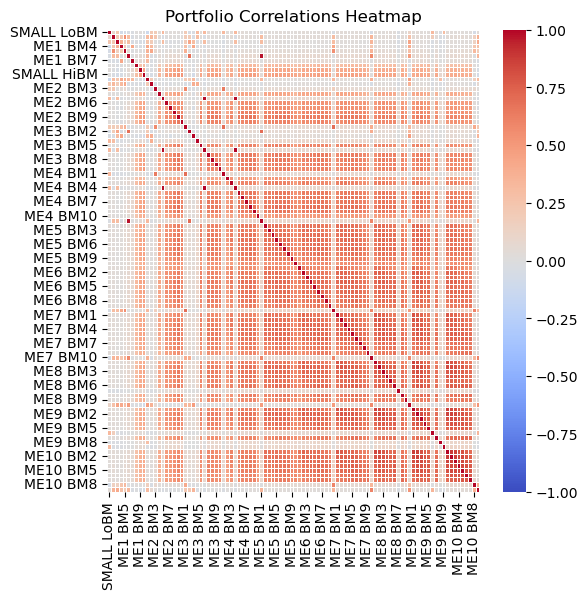

In [4]:
# High correlations were observed between portfolios with similar characteristics.
correlation_matrix = data.corr()

# heat map
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Portfolio Correlations Heatmap')
plt.show()

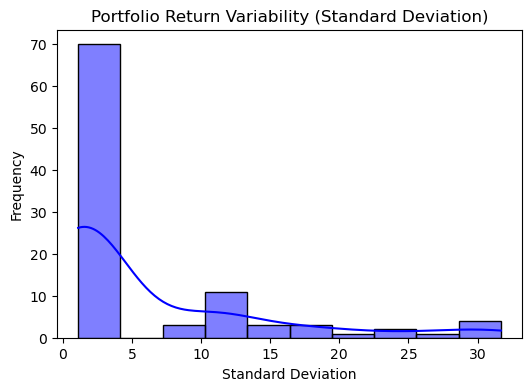

In [5]:
# portfolio return variation(std)
return_variability = data.std()  # each portfolio return's std

# visualization: histogram
plt.figure(figsize=(6, 4))
sns.histplot(return_variability, kde=True, bins=10, color='blue')
plt.title('Portfolio Return Variability (Standard Deviation)')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.show()

# 6 asset MinVar

In [6]:
# Define the training and validation periods
training_start = '2022-12-29'
training_end = '2023-12-29'
validation_date = '2024-01-02'

# Select the first 6 assets
assets = data.columns[:6]
subset_data = data[assets]

# Split the data into training and validation sets
training_data = subset_data.loc[training_start:training_end]
validation_data = subset_data.loc[validation_date]

# Calculate the covariance matrix of the training data
cov_matrix = training_data.cov()

# Get MinVar portfolio weights using the training data covariance matrix
minvar_weights = calculate_minvar_portfolio(cov_matrix)

# Get the actual returns for the assets on the validation date
actual_returns_validation = validation_data.values

# Calculate the predicted portfolio return by multiplying the weights with the actual returns
predicted_portfolio_return = np.dot(minvar_weights, actual_returns_validation)

print(f"Predicted portfolio return on {validation_date}: {predicted_portfolio_return:.3f}")
print(f'weights: {minvar_weights}')

Predicted portfolio return on 2024-01-02: 0.773
weights: [ 0.13608107  0.25476757 -0.09216169  0.15420343  0.22992444  0.31718518]


# 98 asset MinVar

In [7]:
# prepare empty dataframe
current_year = 2024
window_size = 252
df_current_year = data[(data.index.year == current_year)&(data.index < '2024-08-01')]

In [8]:
min_var_weights = window_252(data, df_current_year, weights_func=get_min_var_weights)

100%|██████████| 146/146 [00:51<00:00,  2.81it/s]


In [9]:
# MinVar portfolio sharp ratio

# portfolio return
MinVar_returns = min_var_weights * df_current_year
MinVar_returns = MinVar_returns.sum(axis=1)

# Sharpe Ratio
minvar_sharpe_ratio = sharpe_ratio(MinVar_returns)

# result
print(f"Sharpe Ratio: {minvar_sharpe_ratio}")

Sharpe Ratio: 0.012640759311302673


In [10]:
# EW portfolio sharp ratio

# portfolio return
num_assets = df_current_year.shape[1]
initial_weights = np.ones(num_assets) / num_assets
EW_returns = initial_weights * df_current_year
EW_returns = EW_returns.sum(axis=1)

# Sharpe Ratio
ew_sharpe_ratio = sharpe_ratio(EW_returns)

# result
print(f"Sharpe Ratio: {ew_sharpe_ratio}")

Sharpe Ratio: 0.06449984402785164


# linear regression (LASSO, Ridge)

### LASSO

In [11]:
lasso_weights = window_252(data, df_current_year, weights_func=get_lasso_weight)

100%|██████████| 146/146 [01:12<00:00,  2.00it/s]


In [12]:
# LASSO portfolio sharp ratio

# portfolio return
num_assets = df_current_year.shape[1]
LASSO_returns = lasso_weights * df_current_year
LASSO_returns = LASSO_returns.sum(axis=1)

# Sharpe Ratio
lasso_sharpe_ratio = sharpe_ratio(LASSO_returns)

# result
print(f"Sharpe Ratio: {lasso_sharpe_ratio}")

Sharpe Ratio: 0.10798032008679627


- interpretation of LASSO (test date :2024-01-02)

In [15]:
# Define the training and validation periods
training_start = '2022-12-29'
training_end = '2023-12-29'
validation_date = '2024-01-02'

# Split the data into training and validation sets
training_data = data.loc[training_start:training_end]
validation_data = data.loc[validation_date]

In [16]:
X_train, y_train = prepare_regression_data(training_data, w_ew=initial_weights)

# LASSO
beta_lasso = lasso_regression(X_train, y_train)

# Calculate the portfolio weights using the regression results
N = create_N_matrix(training_data.shape[1])

# Calculate portfolio weights using LASSO and Ridge
w_lasso = calculate_portfolio_weights(initial_weights, beta_lasso, N)

In [17]:
# number of 0 coeffecient
len(beta_lasso[beta_lasso== 0])

69

### Ridge

In [18]:
ridge_weights = window_252(data, df_current_year, weights_func=get_ridge_weight)

100%|██████████| 146/146 [00:01<00:00, 82.85it/s]


In [19]:
# Ridge portfolio sharp ratio

# portfolio return
num_assets = df_current_year.shape[1]
Ridge_returns = ridge_weights * df_current_year
Ridge_returns = Ridge_returns.sum(axis=1)

# Sharpe Ratio
ridge_sharpe_ratio = sharpe_ratio(Ridge_returns)

# result
print(f"Sharpe Ratio: {ridge_sharpe_ratio}")

Sharpe Ratio: 0.10311313580437546


- interpretation of ridge (test date :2024-01-02)

In [20]:
# Define the training and validation periods
training_start = '2022-12-29'
training_end = '2023-12-29'
validation_date = '2024-01-02'

# Split the data into training and validation sets
training_data = data.loc[training_start:training_end]
validation_data = data.loc[validation_date]

In [21]:
X_train, y_train = prepare_regression_data(training_data, w_ew=initial_weights)

# Ridge
beta_ridge = ridge_regression(X_train, y_train)

# Calculate the portfolio weights using the regression results
N = create_N_matrix(training_data.shape[1])

# Calculate portfolio weights using LASSO and Ridge
w_ridge = calculate_portfolio_weights(initial_weights, beta_ridge, N)

In [22]:
# number of 0 coeffecient
len(beta_ridge[beta_ridge== 0])

0

### elasticnet

In [23]:
elasticnet_weights = window_252(data, df_current_year, weights_func=elasticnet_regression)

100%|██████████| 146/146 [23:44<00:00,  9.76s/it]


In [24]:
elasticnet_sharp_ratio, elasticnet_return = return_sharp_ratio(df_current_year, elasticnet_weights)
elasticnet_sharp_ratio

0.17269604314480208

- interpretation of elasticnet

In [25]:
# Define the training and validation periods
training_start = '2022-12-29'
training_end = '2023-12-29'
validation_date = '2024-01-02'

# Split the data into training and validation sets
training_data = data.loc[training_start:training_end]
validation_data = data.loc[validation_date]

In [26]:
X_train, y_train = prepare_regression_data(training_data, w_ew=initial_weights)

# ElasticNetCV: L1_ratio is for adjusting L1, L2 ratio (1.0 is LASSO, 0 is Ridge)
elastic_net = ElasticNetCV(cv=5, l1_ratio=[0.01, 0.1, 0.5, 0.7, 0.9, 1], alphas=np.logspace(-10, 2, 200), fit_intercept=False)
elastic_net.fit(X_train, y_train)

# Calculate the portfolio weights using the regression results
N = create_N_matrix(training_data.shape[1])

# Calculate portfolio weights using LASSO and Ridge
w_elasticnet = calculate_portfolio_weights(initial_weights, elastic_net.coef_, N)

In [27]:
# check best l1_ratio
best_l1_ratio = elastic_net.l1_ratio_

# check best alpha
best_alpha = elastic_net.alpha_

print(f"Optimal l1_ratio: {best_l1_ratio}")
print(f"Optimal alpha: {best_alpha}")

Optimal l1_ratio: 0.01
Optimal alpha: 0.38720387818125573


In [31]:
# number of 0 coeffecient
len(best_alpha[best_alpha== 0])

0

### Bayesian Ridge Regression

In [32]:
#Use PLS regression to compute weights over a rolling window
br_weights = window_252(data, df_current_year, weights_func=BR_regression)

100%|██████████| 146/146 [00:00<00:00, 186.68it/s]


In [33]:
br_sharp_ratio, br_return = return_sharp_ratio(df_current_year, br_weights)
br_sharp_ratio

0.08738476526550695

# Dimension Reduction

### Partial Least Squares Regression (PLS)

In [34]:
pls_weights = window_252(data, df_current_year, weights_func=pls_regression)
pls_sharp_ratio, pls_return = return_sharp_ratio(df_current_year, pls_weights)
pls_sharp_ratio

100%|██████████| 146/146 [00:55<00:00,  2.65it/s]


0.09150209996418235

### Principal Component Analysis Regression (PCA)

In [35]:
pca_weights = window_252(data, df_current_year, weights_func=pcr_regression)

100%|██████████| 146/146 [01:16<00:00,  1.90it/s]


In [36]:
pca_sharp_ratio, pca_return = return_sharp_ratio(df_current_year, pca_weights)
pca_sharp_ratio

0.024601959106127884

# result

In [38]:
print(f'ew_sharpe_ratio:{round(ew_sharpe_ratio, 3)}')
print(f'minvar_sharpe_ratio:{round(minvar_sharpe_ratio, 3)}')

print(f'lasso_sharpe_ratio:{round(lasso_sharpe_ratio, 3)}')
print(f'ridge_sharpe_ratio:{round(ridge_sharpe_ratio, 3)}')

print(f'elasticnet_sharpe_ratio:{round(elasticnet_sharp_ratio, 3)}')
print(f'bayesian_ridge_sharpe_ratio:{round(br_sharp_ratio, 3)}')

print(f'pls_sharpe_ratio:{round(pls_sharp_ratio, 3)}')
print(f'pca_sharp_ratio:{round(pca_sharp_ratio, 3)}')


ew_sharpe_ratio:0.064
minvar_sharpe_ratio:0.013
lasso_sharpe_ratio:0.108
ridge_sharpe_ratio:0.103
elasticnet_sharpe_ratio:0.173
bayesian_ridge_sharpe_ratio:0.087
pls_sharpe_ratio:0.092
pca_sharp_ratio:0.025


In [39]:
print(f'EW_returns : {round(EW_returns.sum(), 3)}')
print(f'MinVar_returns : {round(MinVar_returns.sum(), 3)}')
print(f'LASSO_returns : {round(LASSO_returns.sum(), 3)}')
print(f'Ridge_returns : {round(Ridge_returns.sum(), 3)}')

print(f'elasticnet_returns : {round(elasticnet_return.sum(), 3)}')
print(f'bayesian_returns : {round(br_return.sum(), 3)}')

print(f'pls_returns : {round(pls_return.sum(), 3)}')
print(f'pcr_return : {round(pca_return.sum(), 3)}')

EW_returns : 9.816
MinVar_returns : 1.3
LASSO_returns : 9.021
Ridge_returns : 8.317
elasticnet_returns : 14.143
bayesian_returns : 7.34
pls_returns : 7.489
pcr_return : 30.936


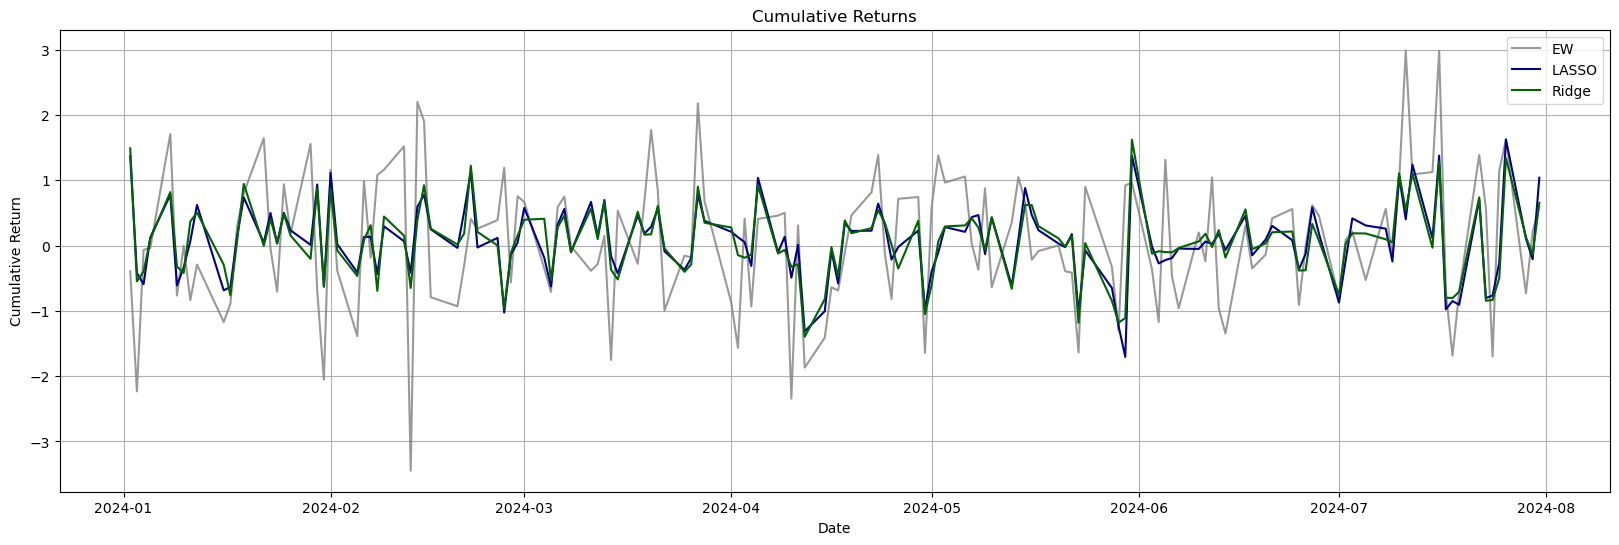

In [42]:
plt.figure(figsize=(20,6))
plt.plot(EW_returns.index, EW_returns, label='EW', color='grey', alpha=0.8)
# plt.plot(MinVar_returns.index, MinVar_returns, label='MinVar', color='darkorange')

plt.plot(LASSO_returns.index, LASSO_returns, label='LASSO', color='darkblue')
plt.plot(Ridge_returns.index, Ridge_returns, label='Ridge', color='darkgreen')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

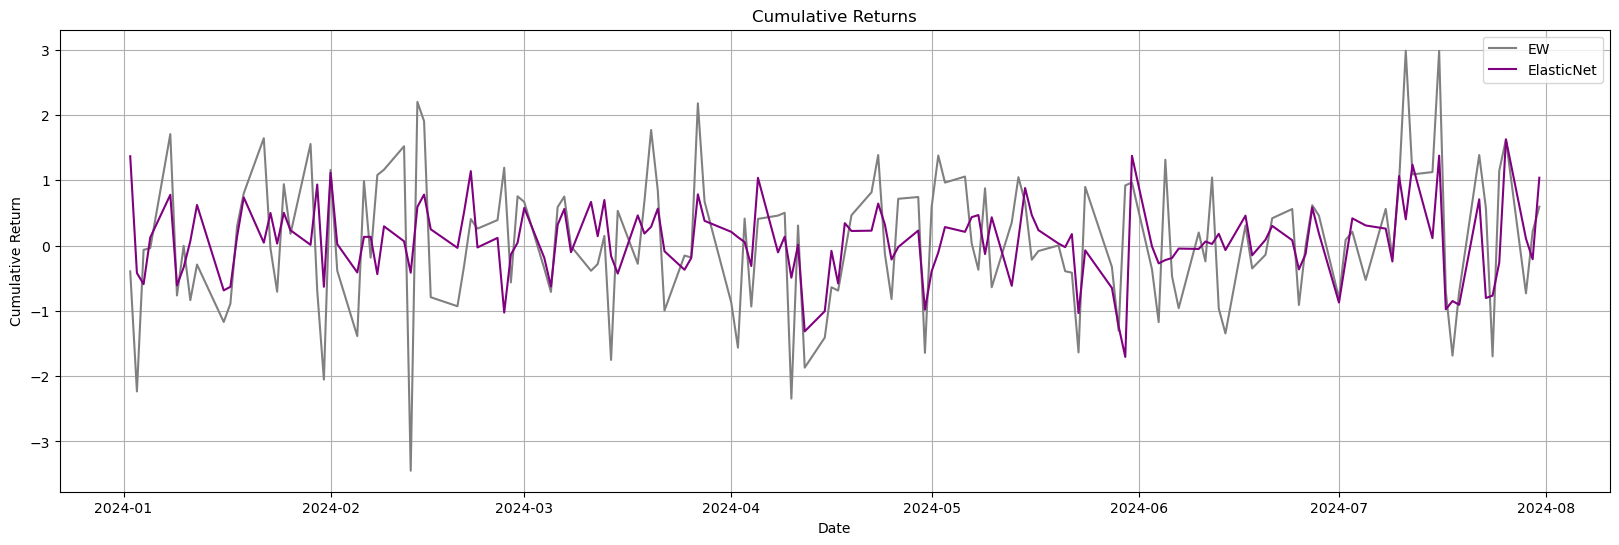

In [43]:
plt.figure(figsize=(20,6))
plt.plot(EW_returns.index, EW_returns, label='EW', color='grey')
# plt.plot(MinVar_returns.index, MinVar_returns, label='MinVar')
# plt.plot(LASSO_returns.index, LASSO_returns, label='LASSO')
# plt.plot(Ridge_returns.index, Ridge_returns, label='Ridge')

plt.plot(elasticnet_return.index, LASSO_returns, label='ElasticNet', color='purple')
# plt.plot(br_return.index, Ridge_returns, label='BayesianRidge')
# plt.plot(pls_return.index, Ridge_returns, label='PLS')

plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()